**Curso de Inteligencia Artificial y Aprendizaje Profundo**


# Autoencoder aplicado a una prueba de Estado

##  Autores

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Oleg Jarma, ojarmam@unal.edu.co
4. Maria del Pilar Montenegro, pmontenegro88@gmail.com

## Referencias

1. 

## Contenido

* [Introducción](#Introducción)
* [Importa módulos](#Importa-módulos)
* [Los datos](#Los-datos)
* [Separa áreas](#Separa-áreas)
* [Separa datos de entrenamiento y validación](#Separa-datos-de-entrenamiento-y-validación)
* [Modelo línea base](#Modelo-línea-base)
* [Compila](#Compila)
* [Entrena](#Entrena)
* [Recupera parámetros de los ítems](#Recupera-parámetros-de-los-ítems)
* [Gráficos](#Gráficos)

## Introducción

## Importa módulos

In [60]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.models import Model

from tensorflow.keras.utils import plot_model

from tensorflow.keras.losses import  binary_crossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.constraints import non_neg

## Los datos

Son 93 items que corresponde a 5 pruebas: 

In [5]:
# Lee los datos
#read csv
#datos = pd.read_csv("../Datos/items_93.csv")
#constructs = pd.read_csv("../Datos/items_areas_93.csv")
# read pickel
datos = pd.read_pickle("../Datos/items_93.pkl")
areas = pd.read_pickle("../Datos/items_areas_93.pkl")

In [4]:
datos.head()

,I1,I2,I3,I4,I5,I6,I7,I9,I10,I12,...,I111,I112,I113,I114,I115,I116,I117,I118,I119,I120
0,1,0,0,0,0,0,0,1,0,1,...,1,0,0,1,0,0,1,1,1,0
1,0,0,0,0,0,0,1,1,1,1,...,1,1,1,0,1,1,1,1,0,0
2,0,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,1,1,0
3,1,1,0,1,0,0,1,1,0,1,...,0,0,0,0,1,0,0,0,1,1
4,1,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,1,1,1


In [45]:
areas.head()

,item,Id_item,construct_name,construct_nick,Id_construct
0,I1,1,Textual,"""T""",1
1,I2,2,Ciencias,"""C""",3
2,I3,3,Ciencias,"""C""",3
3,I4,4,Ciencias,"""C""",3
4,I5,5,Ciencias,"""C""",3


## Separa áreas

In [43]:
# índices de items
tex_item = areas[areas.Id_construct==1]['item'].values
mat_item = areas[areas.Id_construct==2]['item'].values
cie_item = areas[areas.Id_construct==3]['item'].values
soc_item = areas[areas.Id_construct==4]['item'].values
ima_item = areas[areas.Id_construct==5]['item'].values
# Datos por áreas, no requerido de momento
tex_data = pd.DataFrame(datos[tex_item])
mat_data = pd.DataFrame(datos[mat_item])
cie_data = pd.DataFrame(datos[cie_item])
soc_data = pd.DataFrame(datos[soc_item])
ima_data = pd.DataFrame(datos[ima_item])

## Separa datos de entrenamiento y validación

In [48]:
N = len(datos)# 35562

# Porcentaje de entrenamiento

pe = 0.9           # Porcentaje de Entrenamiento
pt = round(1-pe,2) # Porcentaje de Test

# Número de datos de entrenamiento
train = int(N*pe)
# Número de datos de test
test = N-train

# Fijar semilla para reproducibilidad
np.random.seed(11)

# Elegir los indices de las filas a seleccionar para entrenamiento de manera aleatoria
train_choice = np.random.choice(N,train,replace=False)

# Extraer datos seleccionados: features = labels
x_train=datos.iloc[train_choice,:]
print("Tamaño de Datos de Entrenamiento:",x_train.shape)

# Elegir los indices de las filas a seleccionar para test 
test_choice=np.setdiff1d(range(N),train_choice)
# Extraer datos seleccionados
x_test=datos.iloc[test_choice,:]




print("Tamaño de Datos de Test         :",x_test.shape)
print("Total de Datos                 :",len(x_train)+len(x_test))

Tamaño de Datos de Entrenamiento: (32005, 93)
Tamaño de Datos de Test         : (3557, 93)
Total de Datos                 : 35562


## Modelo línea base

### Configuración

In [53]:
dim_1 = datos.shape[1]*2
dim_2 = datos.shape[1]
dim_latent = 5


### Encoder

In [70]:
# encoder
#
inputs_en = Input(shape = (datos.shape[1],))
x = Dense(dim_1, name='hidden_layer_1', activation='relu')(inputs_en)
x = Dense(dim_2, name='hidden_layer_2', activation='relu')(x)
latent = Dense(dim_latent, name='latent_layer', activation='tanh')(x)
#
encoder_lb = Model(inputs=inputs_en,outputs=latent,name='encoder_lb')
#

Model: "encoder_lb"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 93)]              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 186)               17484     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 93)                17391     
_________________________________________________________________
latent_layer (Dense)         (None, 5)                 470       
Total params: 35,345
Trainable params: 35,345
Non-trainable params: 0
_________________________________________________________________


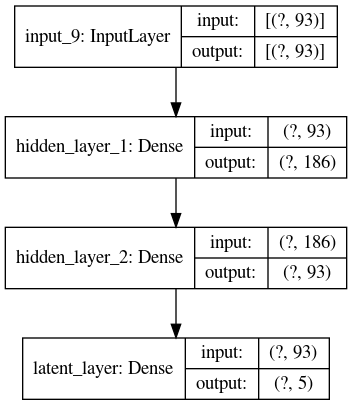

In [68]:
# summary
encoder_lb.summary()
plot_model(encoder_lb, to_file='../Imagenes/encoder_lb.png', 
           show_shapes=True)

### Decoder

In [71]:
# decoder
#
inputs_dec = Input(shape = (dim_latent,))
outputs_dec = Dense(datos.shape[1], name='generate_prob_data',activation='sigmoid',
               kernel_constraint=non_neg())(inputs_dec)
#
decoder_lb = Model(inputs=inputs_dec,outputs= outputs_dec, name='decoder_lb')
#


Model: "decoder_lb"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
generate_prob_data (Dense)   (None, 93)                558       
Total params: 558
Trainable params: 558
Non-trainable params: 0
_________________________________________________________________


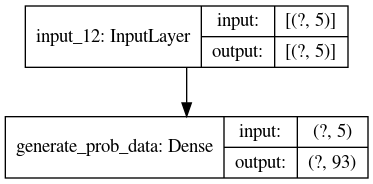

In [72]:
# summary
decoder_lb.summary()
plot_model(decoder_lb, to_file='..\Imagenes\decoder_lb.png', 
           show_shapes=True)

### Autoencoder

In [73]:
# Instantiate autoencoder model
autoencoder_lb = Model(inputs= inputs_en, outputs=decoder_lb(encoder_lb(inputs_en)),
                   name='autoencoder_lb')

#### Summary

Model: "autoencoder_lb"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 93)]              0         
_________________________________________________________________
encoder_lb (Model)           (None, 5)                 35345     
_________________________________________________________________
decoder_lb (Model)           (None, 93)                558       
Total params: 35,903
Trainable params: 35,903
Non-trainable params: 0
_________________________________________________________________


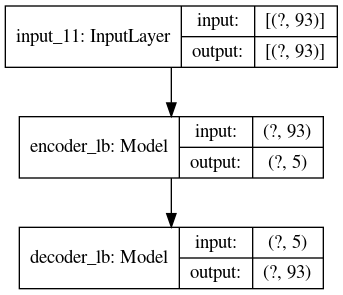

In [74]:
autoencoder_lb.summary()
plot_model(autoencoder_lb, to_file='autoencoder_lb.png',show_shapes=True)

## Compila 

Aquí se introduce el modelo irt 2pl. 

In [78]:
autoencoder_lb.compile(loss= binary_crossentropy,
                  optimizer= Adam(),
                   metrics=['accuracy'])



## Entrena

In [82]:
epochs = 10
batch_size  = 32
#tf.random.set_seed(220)
#
history = autoencoder_lb.fit(x_train,x_train, epochs= epochs,validation_split=0.2,
                             batch_size=batch_size)



Train on 25604 samples, validate on 6401 samples
Epoch 1/20
25604/25604 [==============================] - 5s 187us/sample - loss: 0.5411 - accuracy: 0.7227 - val_loss: 0.5407 - val_accuracy: 0.7227
Epoch 2/20
25604/25604 [==============================] - 4s 164us/sample - loss: 0.5408 - accuracy: 0.7228 - val_loss: 0.5407 - val_accuracy: 0.7228
Epoch 3/20
25604/25604 [==============================] - 4s 167us/sample - loss: 0.5406 - accuracy: 0.7230 - val_loss: 0.5401 - val_accuracy: 0.7233
Epoch 4/20
25604/25604 [==============================] - 4s 164us/sample - loss: 0.5403 - accuracy: 0.7230 - val_loss: 0.5399 - val_accuracy: 0.7234
Epoch 5/20
25604/25604 [==============================] - 4s 165us/sample - loss: 0.5400 - accuracy: 0.7233 - val_loss: 0.5397 - val_accuracy: 0.7232
Epoch 6/20
25604/25604 [==============================] - 5s 181us/sample - loss: 0.5398 - accuracy: 0.7233 - val_loss: 0.5395 - val_accuracy: 0.7233
Epoch 7/20
25604/25604 [===========================

## Recupera parámetros de los ítems

In [128]:
item_params  = decoder_lb.get_weights()
item_params = np.vstack([np.array(item_params[0]),np.array(item_params[1])])
item_params = pd.DataFrame(np .transpose(item_params))

colnames =['dim_1', 'dim_2','dim_3','dim_4','dim_5','intercepto']

item_params.columns =colnames


In [129]:
item_params.head(20)

,dim_1,dim_2,dim_3,dim_4,dim_5,intercepto
0,1.575756,0.715299,0.576411,0.035163,0.597633,0.619022
1,3.188990,2.284241,0.695702,1.152274,1.573791,1.364411
2,0.793893,1.104929,0.076563,0.389713,0.325710,-0.176264
3,0.303462,0.677700,0.001302,0.445908,0.008931,-0.564702
4,0.939626,1.237177,0.183363,0.432744,0.497779,0.534914
5,0.209756,0.530287,0.001283,0.039740,-0.000000,-0.805421
6,1.541651,0.860950,0.350507,0.892942,0.604832,-0.239246
7,0.419799,2.133877,0.176093,0.630504,1.259242,-0.275295
8,0.008027,1.874932,0.050451,0.663180,1.438963,-0.337618
9,0.927296,0.164189,0.297278,-0.000000,0.302067,0.337132


In [130]:
autoencoder_lb.evaluate(x_test,x_test)

3557/3557 [==============================] - 0s 99us/sample - loss: 0.5358 - accuracy: 0.7260


[0.5358467901024485, 0.72598046]

OK:
[loss, accuracy] = [0.5358467901024485, 0.72598046]

## Gráficos

In [137]:
latent_test= encoder_lb(x_test.values).numpy()

In [138]:
latent_test.shape

(3557, 5)

In [148]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [146]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(latent_test)
labels = x_test.index


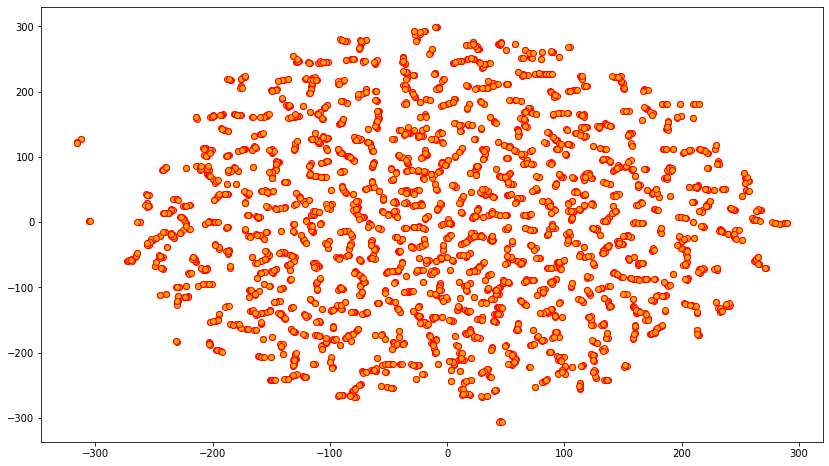

In [151]:
#labels = None
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
#for label, x, y in zip(labels, T[:, 0], T[:, 1]):
#    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
plt.show()

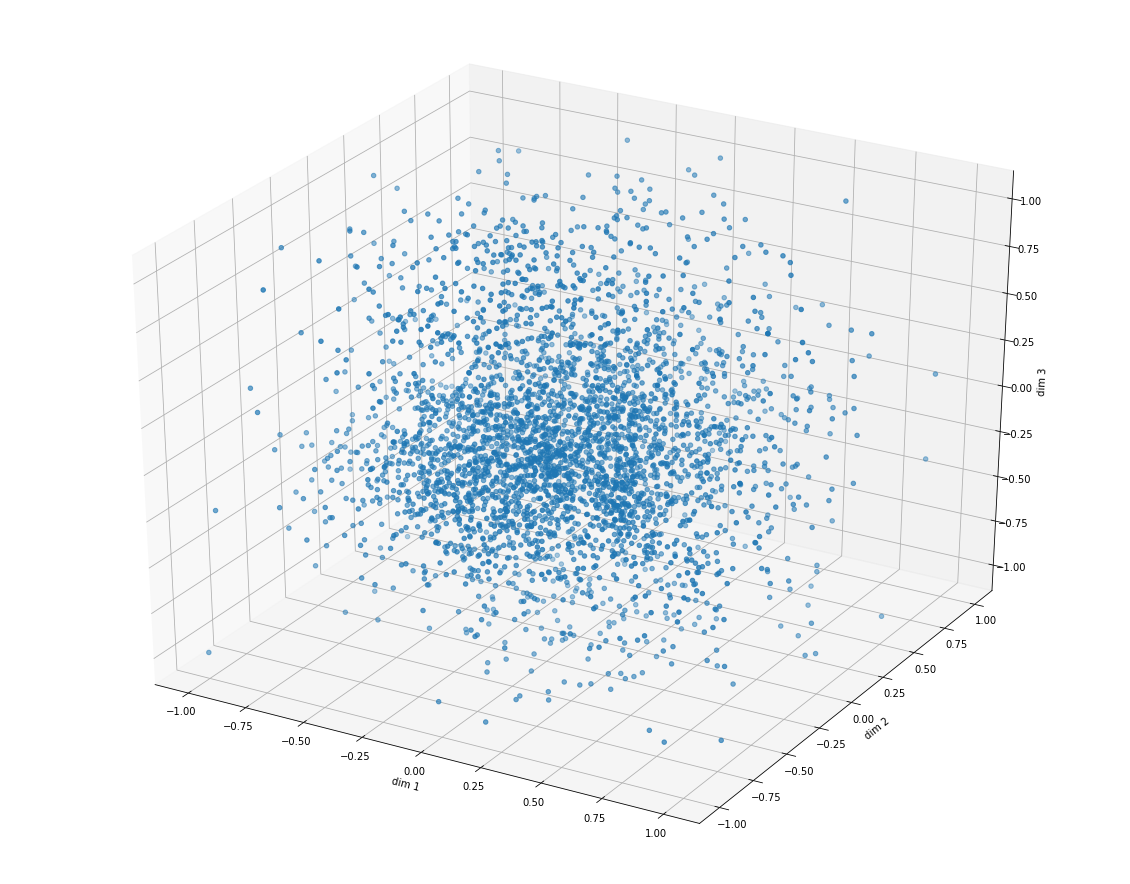

In [144]:
data_plot = latent_test
ax = plt.figure(figsize=(20,16)).gca(projection='3d')
ax.scatter(
    xs=data_plot[:,0],
    ys=data_plot[:,1], 
    zs=data_plot[:,2],
    cmap='tab10',
    )
ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('dim 3')

#ax.set_xlim([0,4])
#ax.set_ylim([-5,0])
#ax.set_zlim([0,4])
plt.show()